**Implementation Notes: "Filtering After Shading With Stochastic Texture Filtering" (NVIDIA, 2024)**

This implementation focuses on Filtering Importance Sampling (FIS) from the paper.
The stochastic approach implements filtering after shading via spatial/temporal accumulation of importance-sampled texels. This is mathematically correct for nonlinear ops as opposed to HW filtering which can introduce bias.

**Advantages:**
* Mathematically unbiased for nonlinear calculations (e.g. lighting calculations).
* Supports sophisticated filters.
* Enables runtime NTC implementation.

**Disadvantages:**
* Requires accumulation (multi-sample) or denoising (e.g., TAA) to reduce variance/noise.
* Final output can differ from HW filtering due to bias introduced by HW filtering.
* Can introduce aliasing during magnification.

References:
* [Filtering After Shading With Stochastic Texture Filtering (2024)](https://research.nvidia.com/publication/2024-05_filtering-after-shading-stochastic-texture-filtering)

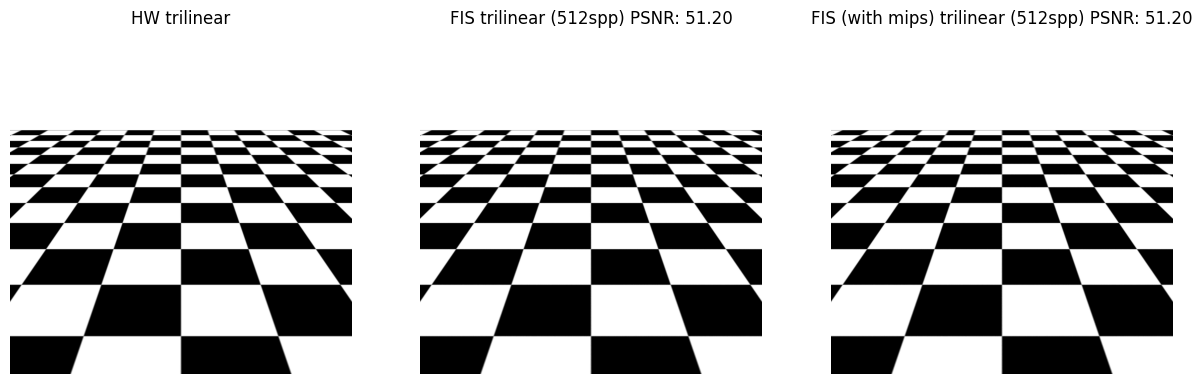

In [3]:
import slangpy as spy
import numpy as np
import matplotlib.pyplot as plt
import os

IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 1024
SAMPLES_PER_PIXEL = 512

# Define vertices and indices for a quad.
class Vertex:
    pos: spy.float3
    uv: spy.float2

    def __init__(self, pos, uv):
        self.pos = pos
        self.uv = uv

    def linear_data(self):
        return [*self.pos, *self.uv]

    def stride(self):
        return len(self.linear_data()) * np.dtype(np.float32).itemsize

    def position_offset(self):
        return 0

    def uv_offset(self):
        return len([*self.pos]) * np.dtype(np.float32).itemsize


quad_vertices = [
    Vertex(
        pos=[-1, 1, 0],
        uv=[0, 0],
    ),
    Vertex(
        pos=[-1, -1, 0],
        uv=[0, 1],
    ),
    Vertex(
        pos=[1, 1, 0],
        uv=[1, 0],
    ),
    Vertex(
        pos=[1, -1, 0],
        uv=[1, 1],
    ),
]
vertex_data = np.array([v.linear_data() for v in quad_vertices], dtype=np.float32)

# Counter-clockwise (default).
index_data = np.array(
    [
        0,
        1,
        2,  # top left triangle
        1,
        3,
        2,  # bottom right triangle
    ],
    dtype=np.uint16,
)

# Init device.
shader_dir = os.getcwd()
device = spy.Device(
    enable_debug_layers=True,
    compiler_options={"include_paths": [shader_dir]},
)

# Create and update vertex and index buffer.
vertex_buffer = device.create_buffer(
    usage=spy.BufferUsage.vertex_buffer,
    data=vertex_data,
    label="quad vertex buffer",
)
index_buffer = device.create_buffer(
    usage=spy.BufferUsage.index_buffer,
    data=index_data,
    label="quad index buffer",
)

# Create texture and sampler.
loader = spy.TextureLoader(device)
texture = loader.load_texture(path="resources/checkerboard.bmp", options={"generate_mips": True})

trilinear_sampler = device.create_sampler(
    min_filter=spy.TextureFilteringMode.linear,
    mag_filter=spy.TextureFilteringMode.linear,
    mip_filter=spy.TextureFilteringMode.linear,
    address_u=spy.TextureAddressingMode.clamp_to_edge,
    address_v=spy.TextureAddressingMode.clamp_to_edge,
)

# Create layout for input assembly.
input_layout = device.create_input_layout(
    input_elements=[
        {
            "semantic_name": "POSITION",
            "semantic_index": 0,
            "format": spy.Format.rgb32_float,
        },
        {
            "semantic_name": "TEXCOORD",
            "semantic_index": 0,
            "format": spy.Format.rg32_float,
            "offset": quad_vertices[0].uv_offset(),
        },
    ],
    vertex_streams=[{"stride": quad_vertices[0].stride()}],
)

# Create render targets.
hw_render_texture = device.create_texture(
    format=spy.Format.rgba32_float,
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    usage=spy.TextureUsage.render_target,
    label="HW trilinear filter",
)

fis_render_texture = device.create_texture(
    format=spy.Format.rgba32_float,
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    usage=spy.TextureUsage.render_target,
    label="FIS trilinear filter",
)

fis_mips_render_texture = device.create_texture(
    format=spy.Format.rgba32_float,
    width=IMAGE_WIDTH,
    height=IMAGE_HEIGHT,
    usage=spy.TextureUsage.render_target,
    label="FIS (with mips) trilinear filter",
)

# Prepare render state.
render_state = spy.RenderState(
    {
        "viewports": [
            spy.Viewport.from_size(hw_render_texture.width, hw_render_texture.height)
        ],
        "scissor_rects": [
            spy.ScissorRect.from_size(hw_render_texture.width, hw_render_texture.height)
        ],
        "vertex_buffers": [vertex_buffer],
        "index_buffer": index_buffer,
        "index_format": spy.IndexFormat.uint16,
    }
)

# Create PSOs for HW, FIS and FIS using mips permutations.
colorTarget = spy.ColorTargetDesc(
    {
        "format": fis_render_texture.format,
        "color": {
            "src_factor": spy.BlendFactor.one,
            "dst_factor": spy.BlendFactor.one,
            "op": spy.BlendOp.add,
        },
        "write_mask": spy.RenderTargetWriteMask.all,
        "enable_blend": True,
    }
)

hw_session = device.create_slang_session(
    {
        "defines": {
            "HW_FILTER": "1",
            "USE_MIP": "0",
        },
    },
)

fis_session = device.create_slang_session(
    {
        "defines": {
            "HW_FILTER": "0",
            "USE_MIP": "0",
        },
    },
)

fis_mips_session = device.create_slang_session(
    {
        "defines": {
            "HW_FILTER": "0",
            "USE_MIP": "1",
        },
    },
)


hw_program = hw_session.load_program(
    "filter_importance_sampling.slang", ["vsMain", "psMain"]
)
hw_pso = device.create_render_pipeline(
    program=hw_program,
    input_layout=input_layout,
    targets=[colorTarget],
)

fis_program = fis_session.load_program(
    "filter_importance_sampling.slang", ["vsMain", "psMain"]
)
fis_pso = device.create_render_pipeline(
    program=fis_program,
    input_layout=input_layout,
    targets=[colorTarget],
)

fis_mips_program = fis_mips_session.load_program(
    "filter_importance_sampling.slang", ["vsMain", "psMain"]
)
fis_mips_pso = device.create_render_pipeline(
    program=fis_mips_program,
    input_layout=input_layout,
    targets=[colorTarget],
)

# Prepare transform for the quad.
model_mat = spy.math.mul(
    spy.math.matrix_from_scaling(spy.float3(3)),
    spy.math.matrix_from_rotation_x(spy.math.radians(-70)),
)
view_mat = spy.math.matrix_from_translation(spy.float3(0, 0, 3) * -1)
projection_mat = spy.math.perspective(spy.math.radians(45), IMAGE_HEIGHT / IMAGE_WIDTH, 0.1, 1000)

transform = spy.math.matrix_from_scaling(spy.float3(1))  # identity
transform = spy.math.mul(projection_mat, view_mat)
transform = spy.math.mul(transform, model_mat)

# Prepare commands and issue draw commands.
command_encoder = device.create_command_encoder()


def render(rt, pso, samples=1):
    with command_encoder.begin_render_pass(
        {"color_attachments": [{"view": rt.create_view({})}]}
    ) as pass_encoder:

        shader_object = pass_encoder.bind_pipeline(pso)
        pass_encoder.set_render_state(render_state)
        param_block = spy.ShaderCursor(shader_object)
        param_block.Transform = transform
        param_block.Texture = texture
        param_block.TrilinearSampler = trilinear_sampler
        param_block.SamplesCount = samples

        for sample_idx in range(samples):
            param_block.SampleIdx = sample_idx
            pass_encoder.draw_indexed({"vertex_count": 6, "instance_count": 1})


render(hw_render_texture, hw_pso)
render(fis_render_texture, fis_pso, SAMPLES_PER_PIXEL)
render(fis_mips_render_texture, fis_mips_pso, SAMPLES_PER_PIXEL)
device.submit_command_buffer(command_encoder.finish())

tev_debug = False
if tev_debug:
    spy.tev.show(hw_render_texture, "HW trilinear filter")
    spy.tev.show(fis_render_texture, "FIS trilinear filter")
    spy.tev.show(fis_mips_render_texture, "FIS (with mips) trilinear filter")


# PSNR
def calcPSNR(target, value):
    mse = np.mean((target - value) ** 2)
    mse = np.inf if mse == 0 else mse
    psnr = 10 * np.log10(1.0 / (mse + 1e-20))
    return psnr


hw_filter = hw_render_texture.to_numpy()
fis_filter = fis_render_texture.to_numpy()
psnr = calcPSNR(hw_filter, fis_filter)

fis_mips_filter = fis_render_texture.to_numpy()
mips_psnr = calcPSNR(hw_filter, fis_mips_filter)

# Show image.
fig = plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(hw_filter)
plt.title("HW trilinear")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(fis_filter)
plt.title(f"FIS trilinear (512spp) PSNR: {psnr:.2f}")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(fis_mips_filter)
plt.title(f"FIS (with mips) trilinear (512spp) PSNR: {mips_psnr:.2f}")
_ = plt.axis("off")